In [193]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stat
import corner
import copy as COPY

%matplotlib nbagg
%matplotlib inline
np.random.seed(1)
plt.style.use('ggplot')
import numba as num

Log(P(D|$\theta)) = N\log{A} - \frac{1}{2w^{2}}(\sum_{i=1}^{N}(x_{i} - x_{o})^{2})     :  A = \frac{1}{\sqrt{w\pi}}$

In [207]:
def prior_transform(u = None):
    a = 12.0*u[0]
    return np.array([a])

def Model(A,x):
    return A*np.exp(-((x-x0)**2)/w**2) 

def Likelihood(data,model,w,N):
    logl = -0.5*N*np.log(w*np.pi) - 0.5*(1/w**2)*(np.sum(data-model))
    return logl

def plus(x,y):
    if x>y:
        return x+np.log(1+np.exp(y-x))
    
    else:
        return y+np.log(1+np.exp(x-y))

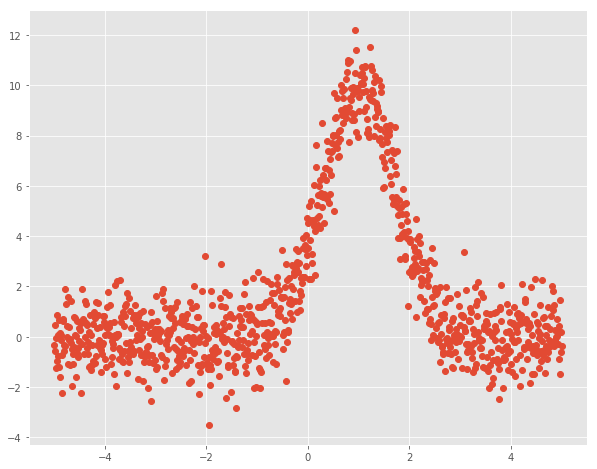

In [208]:
A = 10
w = 1
x0 = 1

x = np.linspace(-5,5,1000)
y_noise = np.random.normal(0,1,1000)

Data = Model(A,x) + y_noise

plt.figure(figsize=(10,8))
plt.plot(x,Data,'o')

In [217]:
n = 200  # Number of live points
ndim = 1
objects = np.zeros((n,ndim))
live_objects = np.zeros((n))

for i in range(n):
    objects[i,:] = prior_transform(u =  np.random.uniform(0,0.6,size=ndim))
    assert objects[i,:].shape == (1,)
    assert type(Model(objects[i,:],x)) == np.ndarray

    live_objects[i] = Likelihood(Data,Model(objects[i,:],x),w,len(x))

In [218]:
nest = 1000
keep = np.zeros((nest,ndim))
logl_sample = []     #Store Log-likelihood of samples
X_sample = []        #Store prior mass
   


logWT = []  #Store  weight =width*likelihood


logZ = -1e300     # SUM(weights)= Z Evidence
H = 0


In [219]:
# Defined intervals for each parameters
Flat_interval = [(0,11)]
mcmc_steps = 30

In [220]:
## MAIN NS LOOP##
accept = 0
reject = 0
#Outer interval 
logw = np.log(1.0 - np.exp(-1.0 / n))

for i in range(nest):
    # Draw worst object with L* from n points
    worst = np.argmin(live_objects)
    
    #Save worst opbject
    keep[i,:] = objects[worst,:]
    logl_sample.append(live_objects[worst])
    
    #Save prior mass
    X_sample.append(logw)
    
    #Weight
    logwt = logw + live_objects[worst]
    
    
    #Save weight
    logWT.append(logwt)
    
    #Update Evidence Z
    logZnew = plus(logZ,logwt)  
    
    #Update H information
    H = np.exp(logwt-logZnew)*live_objects[worst] \
    +np.exp(logZ-logZnew)*(H+logZ)-logZnew
    
    #Update logZ
    logZ = logZnew
    #Shrink interval
    logw -= 1.0/n 
    

    while True:#----copy a random point and do mcmc from there-----
        copy = np.random.randint(len(objects))
        if (copy != worst):break
            
    objects[worst,:] = COPY.deepcopy(objects[copy,:])
    Likelihood_thresh =  live_objects[copy]

    theta = objects[copy,:]
    
    #UNIT TEST check for correct shape
    assert theta.shape == (1,)
    
    scale = 1.0
    for i in range(mcmc_steps):  #Evolve within current worst likelihood L>L* , draw new point under constraint
        
        propose_step = np.random.uniform(0,scale,size=ndim)
        new_point = theta + np.random.uniform(0,scale,size=ndim)
        
        assert new_point.shape == (1,)
        add = 0
        for j in range(len(theta)):
                if Flat_interval[j][0] <= new_point[j] <= Flat_interval[j][1]:
                    add += 1
                else:
                    pass

        if add == len(theta):
            Prior = 1
        else:
            Prior = 0
        
       
    
        Likelihood_new = Likelihood(Data,Model(new_point,x),w,len(x))*Prior
    
        #Acceptance ratio alpha
        alpha = Likelihood_new/Likelihood_thresh
        
        
        if alpha>=1:
            objects[worst,:] = new_point  #Replace worst point with new point
            live_objects[worst] = Likelihood_new   #Replace the worst likelihood with new one  
            accept += 1
            
        else:
            u = np.random.uniform()
            if u <= alpha :
                objects[worst,:] = new_point 
                live_objects[worst] = Likelihood_new
                accept += 1
                
            else:
                u = u
                reject +=1
                
        #Changing the scale
        if accept > reject:
            scale *= np.exp(1./accept)
        if accept < reject:
            scale /= np.exp(1./reject)

    
    
                
    if i >nest*np.exp(H)/np.log(2.):
        break
        

Z = logZ
Z_err = np.sqrt((H)/n)
H = H        #np.exp(H)/np.log(2.)
Acceptance_Ratio = accept/(accept+reject)
print("Acceptance Ratio :",Acceptance_Ratio)
print('Evidence Z = {0} +-{1} : Information H = {2} '.format(Z,Z_err,H))

Acceptance Ratio : 0.7189333333333333
Evidence Z = -489.348674751468 +-0.19336145277666245 : Information H = 7.477730283980293 


In [221]:
#Normalized samples
wt = np.exp((logWT)-max(logWT))
Weights = wt/sum(wt)

#Effective sample size
effective_sample_size = int(np.exp(-np.sum(Weights*np.log(Weights+1e-300))))
S = 0
sample = np.zeros((effective_sample_size,ndim))

# Selecting the Effective sample
while True:
    rnd_point = np.random.randint(len(keep))
    #proba = prob_weighted[rnd_point]/max(prob_weighted)
    proba = Weights[rnd_point]/max(Weights)
    
    if np.random.rand() < proba:
        sample[S,:] = keep[rnd_point,:]
        S += 1
    if S >= effective_sample_size:
        break
print('Effective Sample Size : {}'.format(effective_sample_size))

Effective Sample Size : 16


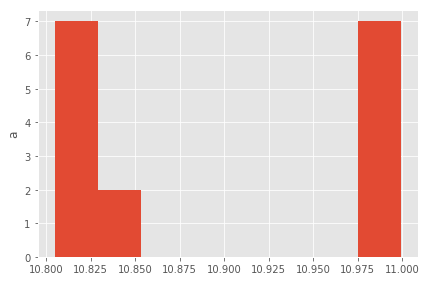

In [222]:
plt.figure(figsize=(15,10))

labels = ['a','b','c','d']
for i in range(1):
    plt.subplot(2,2,i+1)
    plt.hist(sample[:,i],bins=8)
    plt.ylabel(labels[i])
    

In [20]:
a,b,c,d = np.mean(sample[:,0]),np.mean(sample[:,1]),np.mean(sample[:,2]),np.mean(sample[:,2])

In [190]:
Amp = np.mean(sample[:,0])

In [191]:
y_model = Model(Amp,x)

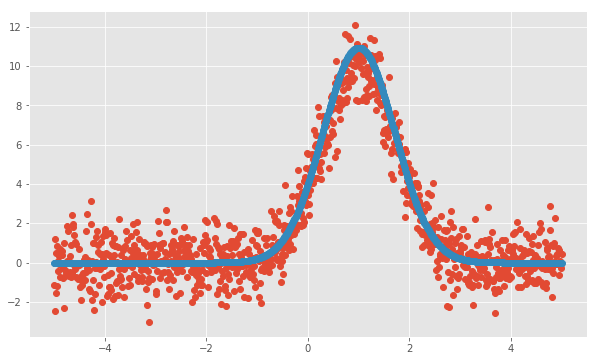

In [192]:
plt.figure(figsize=(10,6))
plt.plot(x,Data,'o')
plt.plot(x,y_model,'o')